In [1]:
#Estimation of reaction rates of bacterial serotonin production from published data, park et al, 2014
#E.coli concentration at OD600=8e8 cells/ml, 
#initial concentration of tryptophan: 3 mM
#initial concentration of serotonin: 0 mM

#Assume 1st order, irreversible reaction (enzymatic, at low concentrations can assume non-MM) 
#Two step reaction, with one rate limiting step, will assume one reaction rate for overall reaction: A -> B -> C

In [21]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

timesRXN = np.array([0.0, 3.0, 6.0, 9.0, 12., 15., 24.]) #hours
serConcRXN = np.array([0.0, 0.055612, 0.124844, 0.147543, 0.173079, 0.181591, 0.209965]) #mM
trpConcRXN = 3.0 - serConcRXN #mM




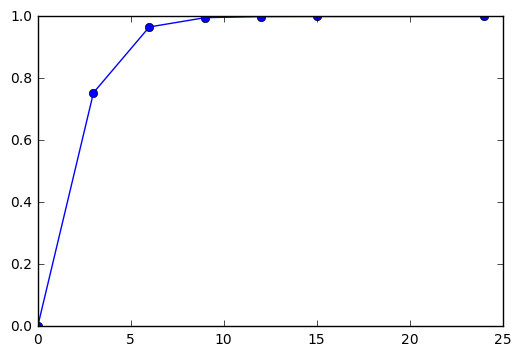

In [69]:
def multistep(times, vmax1, Km1, K1, vmax2, Km2, K2):
    """returns the serotonin concentration at times t"""
    M = len(times)
    y_data = np.zeros(M)
    for i in range(M):
        t = times[i]
        
        def dcdt(c, t):
            """c is a vector of concentrations of Tryptophan, 5-hydroxytryptophoan, and Serotonin"""
            cTry, c5HTP, cSer = c
            k1fwd = vmax1/(Km1+cTry) 
            k1rev = k1fwd/K1
            dcTry = -k1fwd*cTry + k1rev*c5HTP
            
            k2fwd = vmax2/(Km2+c5HTP) 
            k2rev = k2fwd/K2
            dcSer = k2fwd*c5HTP - k2rev*cSer
            
            dc5HTP = -dcTry - dcSer
            return (dcTry, dc5HTP, dcSer)

        co=[3,0,0] #mmol/L
        result = scipy.integrate.odeint(dcdt, co, [0,t])
        #print(result)
        cSer = result[-1,2]
        y_data[i] = cSer
    return y_data

# vmax1, Km1, K1, vmax2, Km2, K2
startingGuessMulti = (1, 1, 1, 10, 1, 1)

plt.plot(timesRXN,multistep(timesRXN, *startingGuessMulti) ,'bo-', label="multi step")

/Users/Cain/anaconda2/envs/py3/lib/python3.5/site-packages/scipy/integrate/odepack.py:218: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


[ 0.1868167   1.43533284  0.43680929  9.97704964  2.37430847  0.25340153]
Parameter 0: 0.18681670002767556 +/- 107.94270109644636 (1 st. dev.)
Parameter 1: 1.4353328363572386 +/- 1152.3847019895875 (1 st. dev.)
Parameter 2: 0.4368092934985146 +/- 252.5372172186933 (1 st. dev.)
Parameter 3: 9.977049643559809 +/- 5162.060165065081 (1 st. dev.)
Parameter 4: 2.3743084748586467 +/- 903.8912223005188 (1 st. dev.)
Parameter 5: 0.25340153474049226 +/- 102.97810591429146 (1 st. dev.)


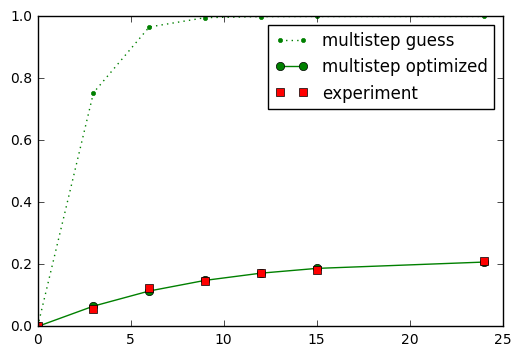

In [72]:
import scipy.optimize
multi_optimal_parameters, multi_covariance = scipy.optimize.curve_fit(multistep, timesRXN, serConcRXN, 
                                                                p0=startingGuessMulti, method = 'trf')
print(multi_optimal_parameters)
report(multi_optimal_parameters, multi_covariance)

plt.plot(timesRXN,multistep(timesRXN, *startingGuessMulti),'g.:', label="multistep guess")
plt.plot(timesRXN,multistep(timesRXN, *multi_optimal_parameters),'go-', label="multistep optimized")
plt.plot(timesRXN, serConcRXN,'rs', label = 'experiment')
plt.legend()


/Users/Cain/anaconda2/envs/py3/lib/python3.5/site-packages/scipy/integrate/odepack.py:218: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)




First Order form of equation 
----------------------------------------

Parameter 0: 0.003924759256632198 +/- 0.0004521308264110699 (1 st. dev.)


Nonelementary form of equation 
----------------------------------------

Parameter 0: 6.763367970888763e-08 +/- 3.063287559296855e-06 (1 st. dev.)
Parameter 1: 11.369265620556604 +/- 40.357758973214736 (1 st. dev.)


Michaelis_Menten form of equation 
----------------------------------------

Parameter 0: 153.3798529880608 +/- 10327.34538609607 (1 st. dev.)
Parameter 1: 0.6132399442182427 +/- 40.54339593427772 (1 st. dev.)


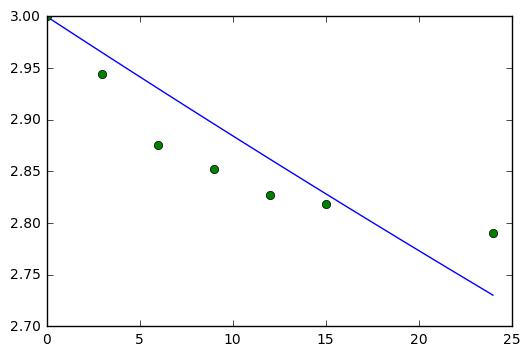

In [22]:
import scipy.optimize
import scipy.integrate

# Adapted Professor West's solution to regression assignment

def first_order(times, k):
    M = len(times)
    y_data = np.zeros(M)
    for i in range(M):
        t = times[i]
        
        def dcAdt(cA, t):
            return -1.*k*cA

        cAo=3 #mmol/L
        result = scipy.integrate.odeint(dcAdt, cAo, [0,t])
        cA = result[-1,0]
        y_data[i] = cA
    return y_data

def nonelementary(times, k, n):
    """
    fitting to a R_a = k*C_a^n
    """
    M = len(times)
    y_data = np.zeros(M)
    for i in range(M):
        t = times[i]
        
        def dcAdt(cA, t):
            return -1.*k*cA**n

        cAo=3 #mmol/L
        result = scipy.integrate.odeint(dcAdt, cAo, [0,t])
        cA = result[-1,0]
        y_data[i] = cA
    return y_data

    
def Michaelis_Menten(times,K_m,v_max):
    """
    Trying out a Michaelis_Menten fit for reaction kinetics of tryptophan to serotonin
    """
    M = len(times)
    y_data = np.zeros(M)

    for i in range(M):
        t = times[i]
        
        def dcAdt(cA, t):
            return -1.0*v_max*cA/(cA+K_m)
    
        cAo=3 #mmol/L
        result = scipy.integrate.odeint(dcAdt, cAo, [0,t])
        cA = result[-1,0]
        y_data[i] = cA
    return y_data

startingGuessFO = (1e-3)
startingGuessNE = (1, 1)
startingGuessMM = (3, 1)

fo_optimal_parameters, fo_covariance = scipy.optimize.curve_fit(first_order, timesRXN, trpConcRXN, 
                                                                p0=startingGuessFO, method = 'trf')

ne_optimal_parameters, ne_covariance = scipy.optimize.curve_fit(nonelementary, timesRXN, trpConcRXN, 
                                                                p0=startingGuessNE, method = 'trf')

mm_optimal_parameters, mm_covariance = scipy.optimize.curve_fit(Michaelis_Menten, timesRXN, trpConcRXN, 
                                                                p0=startingGuessMM, method = 'trf')


def report(optimal_parameters, covariance):
    "Make this a function so we can reuse it in cells below"
    parameter_errors = np.sqrt(np.diag(covariance))
    for i in range(len(optimal_parameters)):
        print("Parameter {}: {} +/- {} (1 st. dev.)".format(i,
                                                            optimal_parameters[i],
                                                            parameter_errors[i]))
        
print('\n\nFirst Order form of equation \n' + '-'*40 + '\n')
report(fo_optimal_parameters, fo_covariance)        
print('\n\nNonelementary form of equation \n' + '-'*40 + '\n')
report(ne_optimal_parameters, ne_covariance)
print('\n\nMichaelis_Menten form of equation \n' + '-'*40 + '\n')
report(mm_optimal_parameters, mm_covariance)

x_many_points = np.linspace(timesRXN.min(),timesRXN.max(),50)
plt.plot(x_many_points, Michaelis_Menten(x_many_points, *mm_optimal_parameters), label='fitted')
plt.plot(timesRXN, trpConcRXN,'o', label = 'experiment')

plt.show()



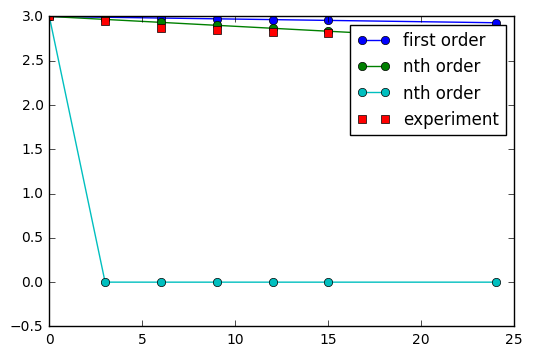

In [59]:
startingGuessFO = (1e-3)
startingGuessNE = (1e-2, 0.1)
startingGuessMM = (3e-5, 1e0)

plt.plot(timesRXN,first_order(timesRXN, startingGuessFO) ,'bo-', label="first order")
plt.plot(timesRXN,nonelementary(timesRXN, *startingGuessNE),'go-', label="nth order")
plt.plot(timesRXN,Michaelis_Menten(timesRXN, *startingGuessMM),'co-', label="nth order")
plt.plot(timesRXN, trpConcRXN,'rs', label = 'experiment')
plt.legend()

In [8]:
#above assumes a concentration of 8e8 bacteria per mL
#Based on average intestinal (small and large) volume of 130 mL
#and total microbes in the body, 10^14, concentrations could be high as 10^14/130 per mL
#but not all produce serotonin

serProdMicrobeMax = 10e14/130 #bacteria per mL
serProdMicrobeMin = serProdMicrobeMax*0.000001


#Adjustments to k value based on bacterial concentration 
#serConcRXNMin = (serProdMicrobeMin/8e8)*serConcRXN
#trpConcRXNMin = 3.0 - serConcRXNMin
#serConcRXNMax = (serProdMicrobeMax/8e8)*serConcRXN
#trpConcRXNMax = 3.0 - serConcRXNMax

#does not account for change in RATE how to account for differences based on differences in number of bacteria from this data?


optimal_parametersMin, covarianceMin = scipy.optimize.curve_fit(RXNfunction, timesRXN, trpConcRXNMin)
optimal_parametersMax, covarianceMax = scipy.optimize.curve_fit(RXNfunction, timesRXN, trpConcRXNMax)

report(optimal_parametersMin, covarianceMin)
report(optimal_parametersMax, covarianceMax)

plt.plot(timesRXN, trpConcRXNMin)
plt.plot(timesRXN, trpConcRXNMax)
plt.plot(x_many_points, RXNfunction(x_many_points, *optimal_parametersMin), label='fitted')
plt.plot(x_many_points, RXNfunction(x_many_points, *optimal_parametersMax), label='fitted')
    
plt.show()
    


NameError: name 'RXNfunction' is not defined